## Bidirectional_LSTM - Time Serise Dataset

- 서울시 기후 데이터 : 2011년 01월 01일 ~ 2019년 12월 31일
- https://data.kma.go.kr/cmmn/main.do
- 기후통계분석 -> 기온분석 -> 기간(20110101~20191231) -> - - 검색 -> CSV 다운로드
- Seoul_Temp.csv

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import Packages

- Packages

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# I. Colab File Upload

> ## 1) 'Seoul_Temp.csv' 파일을 Colab에 업로드 후 진행

In [4]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


In [5]:
temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


# II. Data Preprocessing

> ## 1) 일일 평균온도('avg') 변화 시각화

- 일일 평균온도 변화에 일정한 패턴 확인

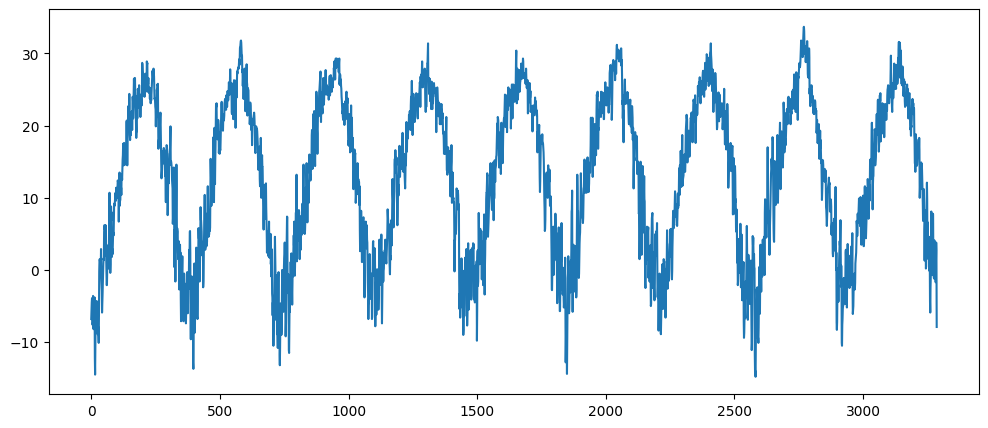

In [6]:
temp_data = temp[['avg']]

plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

> ## 2) Normalization

  - tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

temp_data = scaler.fit_transform(temp_data)

> ## 3) Train vs. Test Split

- Train_Dataset : 2011년 01월 01일 ~ 2017년 12월 31일
- Test_Dataset : 2018년 01월 01일 ~ 2019년 12월 31일

In [8]:
train = temp_data[0:2557]
test = temp_data[2557:]

# III. 시계열 데이터 처리 함수

> ## 1) 시계열 학습용 데이터 생성 함수 정의

  - X : 학습 평균온도 데이터
  - y : 정답 평균온도 데이터
  - 일정 기간의 X로 y를 예측하도록 학습

In [9]:
def create_dataset(time_data, look_back = 1):
  data_X, data_y = [], []

  for i in range(len(time_data) - look_back):
      data_X.append(time_data[i:(i + look_back), 0])
      data_y.append(time_data[i + look_back, 0])

  return np.array(data_X), np.array(data_y) 

> ## 2) loop_back 기간 설정 후 학습데이터 생성

- 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

In [10]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X, test_y = create_dataset(test, look_back)

train_X.shape, test_X.shape, train_y.shape, test_y.shape

((2377, 180), (550, 180), (2377,), (550,))

> ## 3) Tensor Reshape

In [11]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, test_X.shape, train_y.shape, test_y.shape

((2377, 180, 1), (550, 180, 1), (2377,), (550,))

# IV. Bidriectional LSTM Modeling

> ## 1) Model Define

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional

model = Sequential(name = 'BidirectionalLSTM')
model.add(Bidirectional(LSTM(64,
               input_shape = (None, 1))))
model.add(Dense(1, activation = 'tanh'))


> ## 2) Model Compile

In [15]:
model.compile(loss = 'mse',
              optimizer = 'rmsprop',
              metrics = ['mae'])

> ## Model Fit
  
  - 약 10분
  

In [16]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 200,
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/200
149/149 [==============================] - 12s 19ms/step - loss: 0.0208 - mae: 0.1088 - val_loss: 0.0145 - val_mae: 0.0940
Epoch 2/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0149 - mae: 0.0948 - val_loss: 0.0125 - val_mae: 0.0859
Epoch 3/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0132 - mae: 0.0879 - val_loss: 0.0111 - val_mae: 0.0811
Epoch 4/200
149/149 [==============================] - 2s 17ms/step - loss: 0.0122 - mae: 0.0846 - val_loss: 0.0112 - val_mae: 0.0817
Epoch 5/200
149/149 [==============================] - 2s 14ms/step - loss: 0.0111 - mae: 0.0807 - val_loss: 0.0096 - val_mae: 0.0744
Epoch 6/200
149/149 [==============================] - 2s 12ms/step - loss: 0.0104 - mae: 0.0780 - val_loss: 0.0107 - val_mae: 0.0807
Epoch 7/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0098 - mae: 0.0756 - val_loss: 0.0092 - val_mae: 0.0730
Epoch 8/200
149/149 [==============================] - 2s 12m

> ## 4) 학습결과 시각화

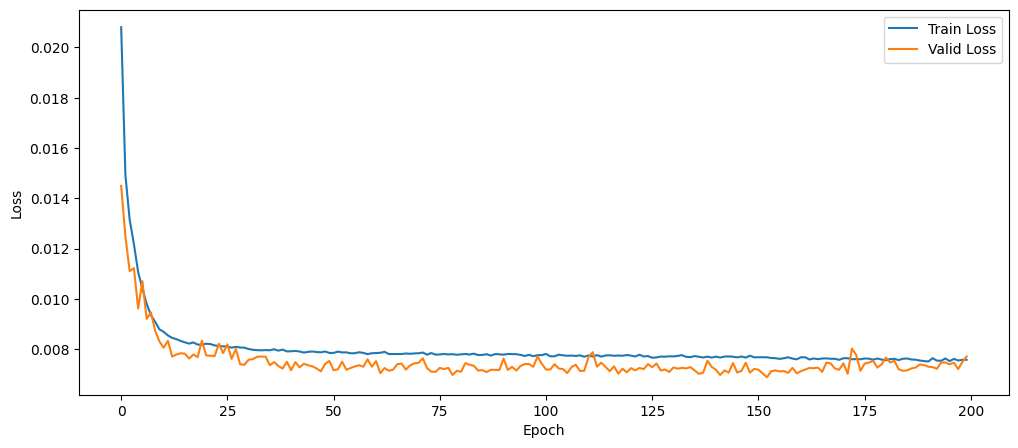

In [17]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

> ## 5) Model Evaludate

In [18]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score : ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score : ', testScore)

Train Score :  [0.007624484598636627, 0.06452103704214096]
Test Score :  [0.007717343978583813, 0.06662372499704361]


# V. Model Predict

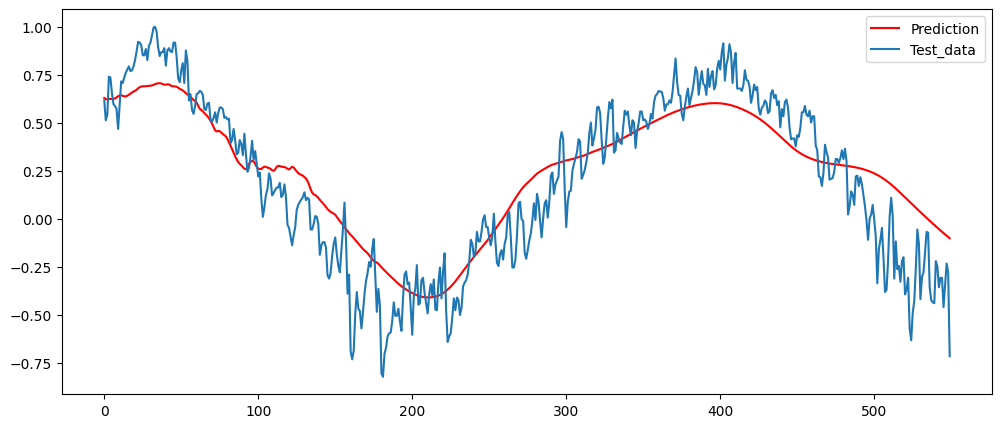

In [19]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1, verbose = 0)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
  
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_data')
plt.legend()
plt.show()